## Drydown model results analys

In [1]:
from climate_utils import global_mean


In [2]:
import numpy as np
import pandas as pd
import xarray as xr

# progress bars for loops
from tqdm.notebook import tqdm  


## for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns


import string
from os.path import exists


## Import Data

When importing the datasets, we're renaming the variables so that all the models match and things are a bit easier to deal with

In [3]:
dict_ds = {'MERRA2': {}, 
           'NLDAS_MOS': {}, 
           'NLDAS_NOAH': {}
       }

proj_dir = '/Users/miriam/Documents/02_academia/02_PhD/research/projects/drydown-model/'
filtered_seasons_dir = proj_dir + 'filtered_seasons/'
fig_save_dir = proj_dir + 'figures/'

In [4]:
model_params = {'MERRA2': {'filename': 'MERRA2_warm-season_1980-2023.nc', 
                           'p_var': 'PRECTOTLAND', 
                           't_var': 'T2MMEAN', 
                           'sf_var': 'SFMC',
                           'rz_var': 'RZMC',
                           'snowfall_var': 'PRECSNOLAND', 
                           'snowdepth_var': 'SNODP', 
                           'model_name': 'MERRA-2'
                          },
                 'NLDAS_MOS': {'filename': 'NLDAS_MOS_warm-season_1980-2023.nc', 
                           'p_var': 'Rainf', 
                           't_var': 'Tair', 
                           'sf_var': 'SoilM_0_10cm',
                           'rz_var': 'SoilM_0_100cm',
                           'snowfall_var': 'Snowf', 
                           'snowdepth_var': 'SnowDepth', 
                               'model_name': 'NLDAS-2 MOSAIC'          
                          },
                'NLDAS_NOAH': {'filename': 'NLDAS_NOAH_warm-season_1980-2023.nc', 
                           'p_var': 'Rainf', 
                           't_var': 'Tair', 
                           'sf_var': 'SoilM_0_10cm',
                           'rz_var': 'SoilM_0_100cm',
                           'snowfall_var': 'Snowf', 
                           'snowdepth_var': 'SnowDepth', 
                               'model_name': 'NLDAS-2 NOAH'
                          }
               }

### Import underlying warm season dataset

In [5]:

for model in tqdm(dict_ds.keys()):
    print(model)

    ### open seasonal datasets 
    dict_ds[model] = xr.open_mfdataset(filtered_seasons_dir + model_params[model]['filename'], 
                         parallel = True).load()



    ### STILL TRYING TO FIGURE OUT WHAT IS THE BEST FOR P HERE 
    
    # ## typical moisture infusion for the entire time period 
    #dict_ds[model]['mean_p_div_m'] = (dict_ds[model][model_params[model]['p_var']]/dict_ds[model][model_params[model]['sf_var']]).mean(dim = 'time')
    #dict_ds[model]['median_p_div_m'] = (dict_ds[model][model_params[model]['p_var']]/dict_ds[model][model_params[model]['sf_var']]).median(dim = 'time')

    dict_ds[model] = dict_ds[model].rename({model_params[model]['sf_var']: 'SFMC', 
                                            model_params[model]['rz_var']: 'RZMC',
                                            model_params[model]['t_var']: 'T',
                                            model_params[model]['p_var']: 'P', 
                                            model_params[model]['snowfall_var']: 'Snowfall',
                                            model_params[model]['snowdepth_var']: 'Snowdepth'
                                           })




  0%|          | 0/3 [00:00<?, ?it/s]

MERRA2
NLDAS_MOS
NLDAS_NOAH


### Import drydown results dataset

In [6]:
model_process_dir = 'model_results/'

dict_processed = {}

for model in tqdm(dict_ds.keys()):
    fname = f'{proj_dir}{model_process_dir}{model}_warm_season_drydown_model_results.nc'
    if exists(fname):
        ## open dataset
        ds = xr.open_dataset(fname, decode_times = False).load()

        ## update tau value to make sure it is the current working definition
        ds['tau'] = ds.fitted_lambda * np.log(1 + ds.fitted_a * (dict_ds[model]['P']/dict_ds[model]['SFMC']).mean(dim = 'time'))
        ds['tau'].attrs['units'] = 'days'
        ds['tau'].attrs['short description'] = 'Drydown time calculated as lambda * np.log(1 + time series mean precipitation/time series mean surface soil moisture)'

        dict_processed[model] = ds
    
    else:
        print(f'drydown results for {model} do not exist, check filename or run `02_drydown_model`')


  0%|          | 0/3 [00:00<?, ?it/s]

## Combine combine combine

In [7]:
dict_all = {}

for model in tqdm(dict_processed.keys()):
    ds_drydown = dict_processed[model]
    ds_warm_season = dict_ds[model].groupby('time.year').median()

    # Merge the two datasets on (lat, lon, year)
    dict_all[model] = xr.merge([ds_drydown, ds_warm_season])


  0%|          | 0/3 [00:00<?, ?it/s]

## 3 x 3 Plot 

In [67]:
def three_by_three_plot(variables, plot_params, hashing = False):
    fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (18, 18), 
                             subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
    
    # Define the same extent for all plots
    shared_extent = [-125, -100, 25, 49.2]  # Example extent [lon_min, lon_max, lat_min, lat_max]
    
    subplot_idx = 0
    
    for i, var in enumerate(variables): 
        cmap = plt.get_cmap(plot_params[var]['cmap'])
        levels = np.linspace(plot_params[var]['vmin'], plot_params[var]['vmax'], plot_params[var]['levels'])
        extend = plot_params[var]['extend']
        norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, extend = extend)
                
        for j, model in enumerate(dict_all.keys()):
            ax = axes[i,j]
            im = dict_all[model][var].median(dim = 'year').plot(ax = ax, extend = extend,
                                                           vmin = plot_params[var]['vmin'],
                                                           vmax = plot_params[var]['vmax'],
                                                           #cmap = plot_params[var]['cmap'],
                                                           #levels = plot_params[var]['levels'],
                                                            levels = levels,
                                                            cmap = cmap,
                                                            norm = norm,
                                                           transform = ccrs.PlateCarree(), 
                                                           add_colorbar = False)
    
            # Add map features
            ax.set_extent(shared_extent, crs=ccrs.PlateCarree())  # Apply the shared extent
        
            ax.coastlines('10m')
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.STATES)
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.add_feature(cfeature.LAND, edgecolor='black')
    
            # Subplot lettering from Kevin S
            #  subplot letter from string.ascii_lowercase
            ax.text(0.01, 0.98, string.ascii_lowercase[subplot_idx] + '.', 
                    transform=ax.transAxes, ha='left', va='top',
                    fontsize=18, fontweight='bold',
                    bbox={'boxstyle': 'round',
                          'facecolor': 'white',
                          'alpha': 0.8,
                          'edgecolor': 'None',
                          'pad': 0.2})
            
            if hashing == True:
                low_r2_mask = dict_all[model]['r2'].median(dim = 'year') < 0.5
                ax.contourf(
                    low_r2_mask.lon, low_r2_mask.lat, low_r2_mask.astype(int), 
                    levels=[-0.5, 0.5, 1.5],
                    hatches=['', '////'],  # '////' creates angled hash lines
                    #hatches=['', 'xx'],
                    #hatches=['', '\\\\'],
                    colors='none',  # Transparent fill
                    transform=ccrs.PlateCarree(),
                    zorder=5
                )
            
            
            subplot_idx += 1  # Increment for next subplot
        
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    
            # Set gridlines labels only on left and bottom
            gl.top_labels = False
            gl.right_labels = False
    
            # Show latitude labels only on the first subplot
            if j == 0:
                gl.left_labels = True
                ax.set_xlabel(plot_params[var]['var_name'], fontweight = 'bold')
            else:
                gl.left_labels = False
    
            if i == 0:
                ax.set_title(model_params[model]['model_name'], fontweight = 'bold')
                
    
        cax_position = axes[i, -1].get_position()
        cbar_ax = fig.add_axes([cax_position.x1 + 0.02, cax_position.y0, 0.02, cax_position.y1 - cax_position.y0])  # [left, bottom, width, height]
        cbar = fig.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
        if 'units' in dict_all[model][var].attrs:
            cbar.set_label(f'{plot_params[var]["var_name"]} [{dict_all[model][var].attrs["units"]}]')
        else: 
            cbar.set_label(f'{plot_params[var]["var_name"]}')
        cbar.set_ticks(levels)
    
    
    plt.subplots_adjust(right=0.9)  # make space for ducklings (colorbars)
    fig.savefig(f'{fig_save_dir}three_by_three-{"%s" % "-".join(variables)}.png', bbox_inches='tight')
      
    

In [68]:
plot_params = {'length_of_season': {'cmap': 'Oranges', 
                                    'levels': 13,
                                    'vmin': 0, 'vmax': 360,
                                    'unit': 'days', 
                                    'var_name': 'Length of warm seasons',
                                    'ticks': [0, 60, 120,  180,  240,  300,  360],
                                    'labels':[0, 60, 120,  180,  240,  300,  360],
                                    'extend': 'max'
              },
               'SFMC': {'cmap': 'Greens',
                        'extend': 'neither',
                      'levels': 9, 
                      'vmin': 0,
                      'vmax': 40, 
                      'var_name': 'Surface soil moisture',
                      #'ticks': None
                     },
               'P': {'cmap': 'BuPu', 
                     'extend':'max',
                   'levels': 7, 
                   'vmin': 0,
                   'vmax': 0.5, 
                   'var_name': 'Precipitation'
                  },
               'fitted_a': {'cmap': 'BuPu', 
                            'extend': 'neither',
                   'levels': 11, 
                   'vmin': 0,
                   'vmax': 1, 
                   'var_name': 'a'
                  },
               'fitted_lambda': {'cmap': 'YlGn', 
                                 'extend': 'max',
                   'levels': 9, 
                   'vmin': 0,
                   'vmax': 400, 
                   'var_name': '$\lambda$'
                  },
               'tau': {'cmap': 'YlGn', 
                       'extend': 'neither',
                   'levels': 9, 
                   'vmin': 0,
                   'vmax': 1.6, 
                   'var_name': 'drydown, τ'
                  },
              }

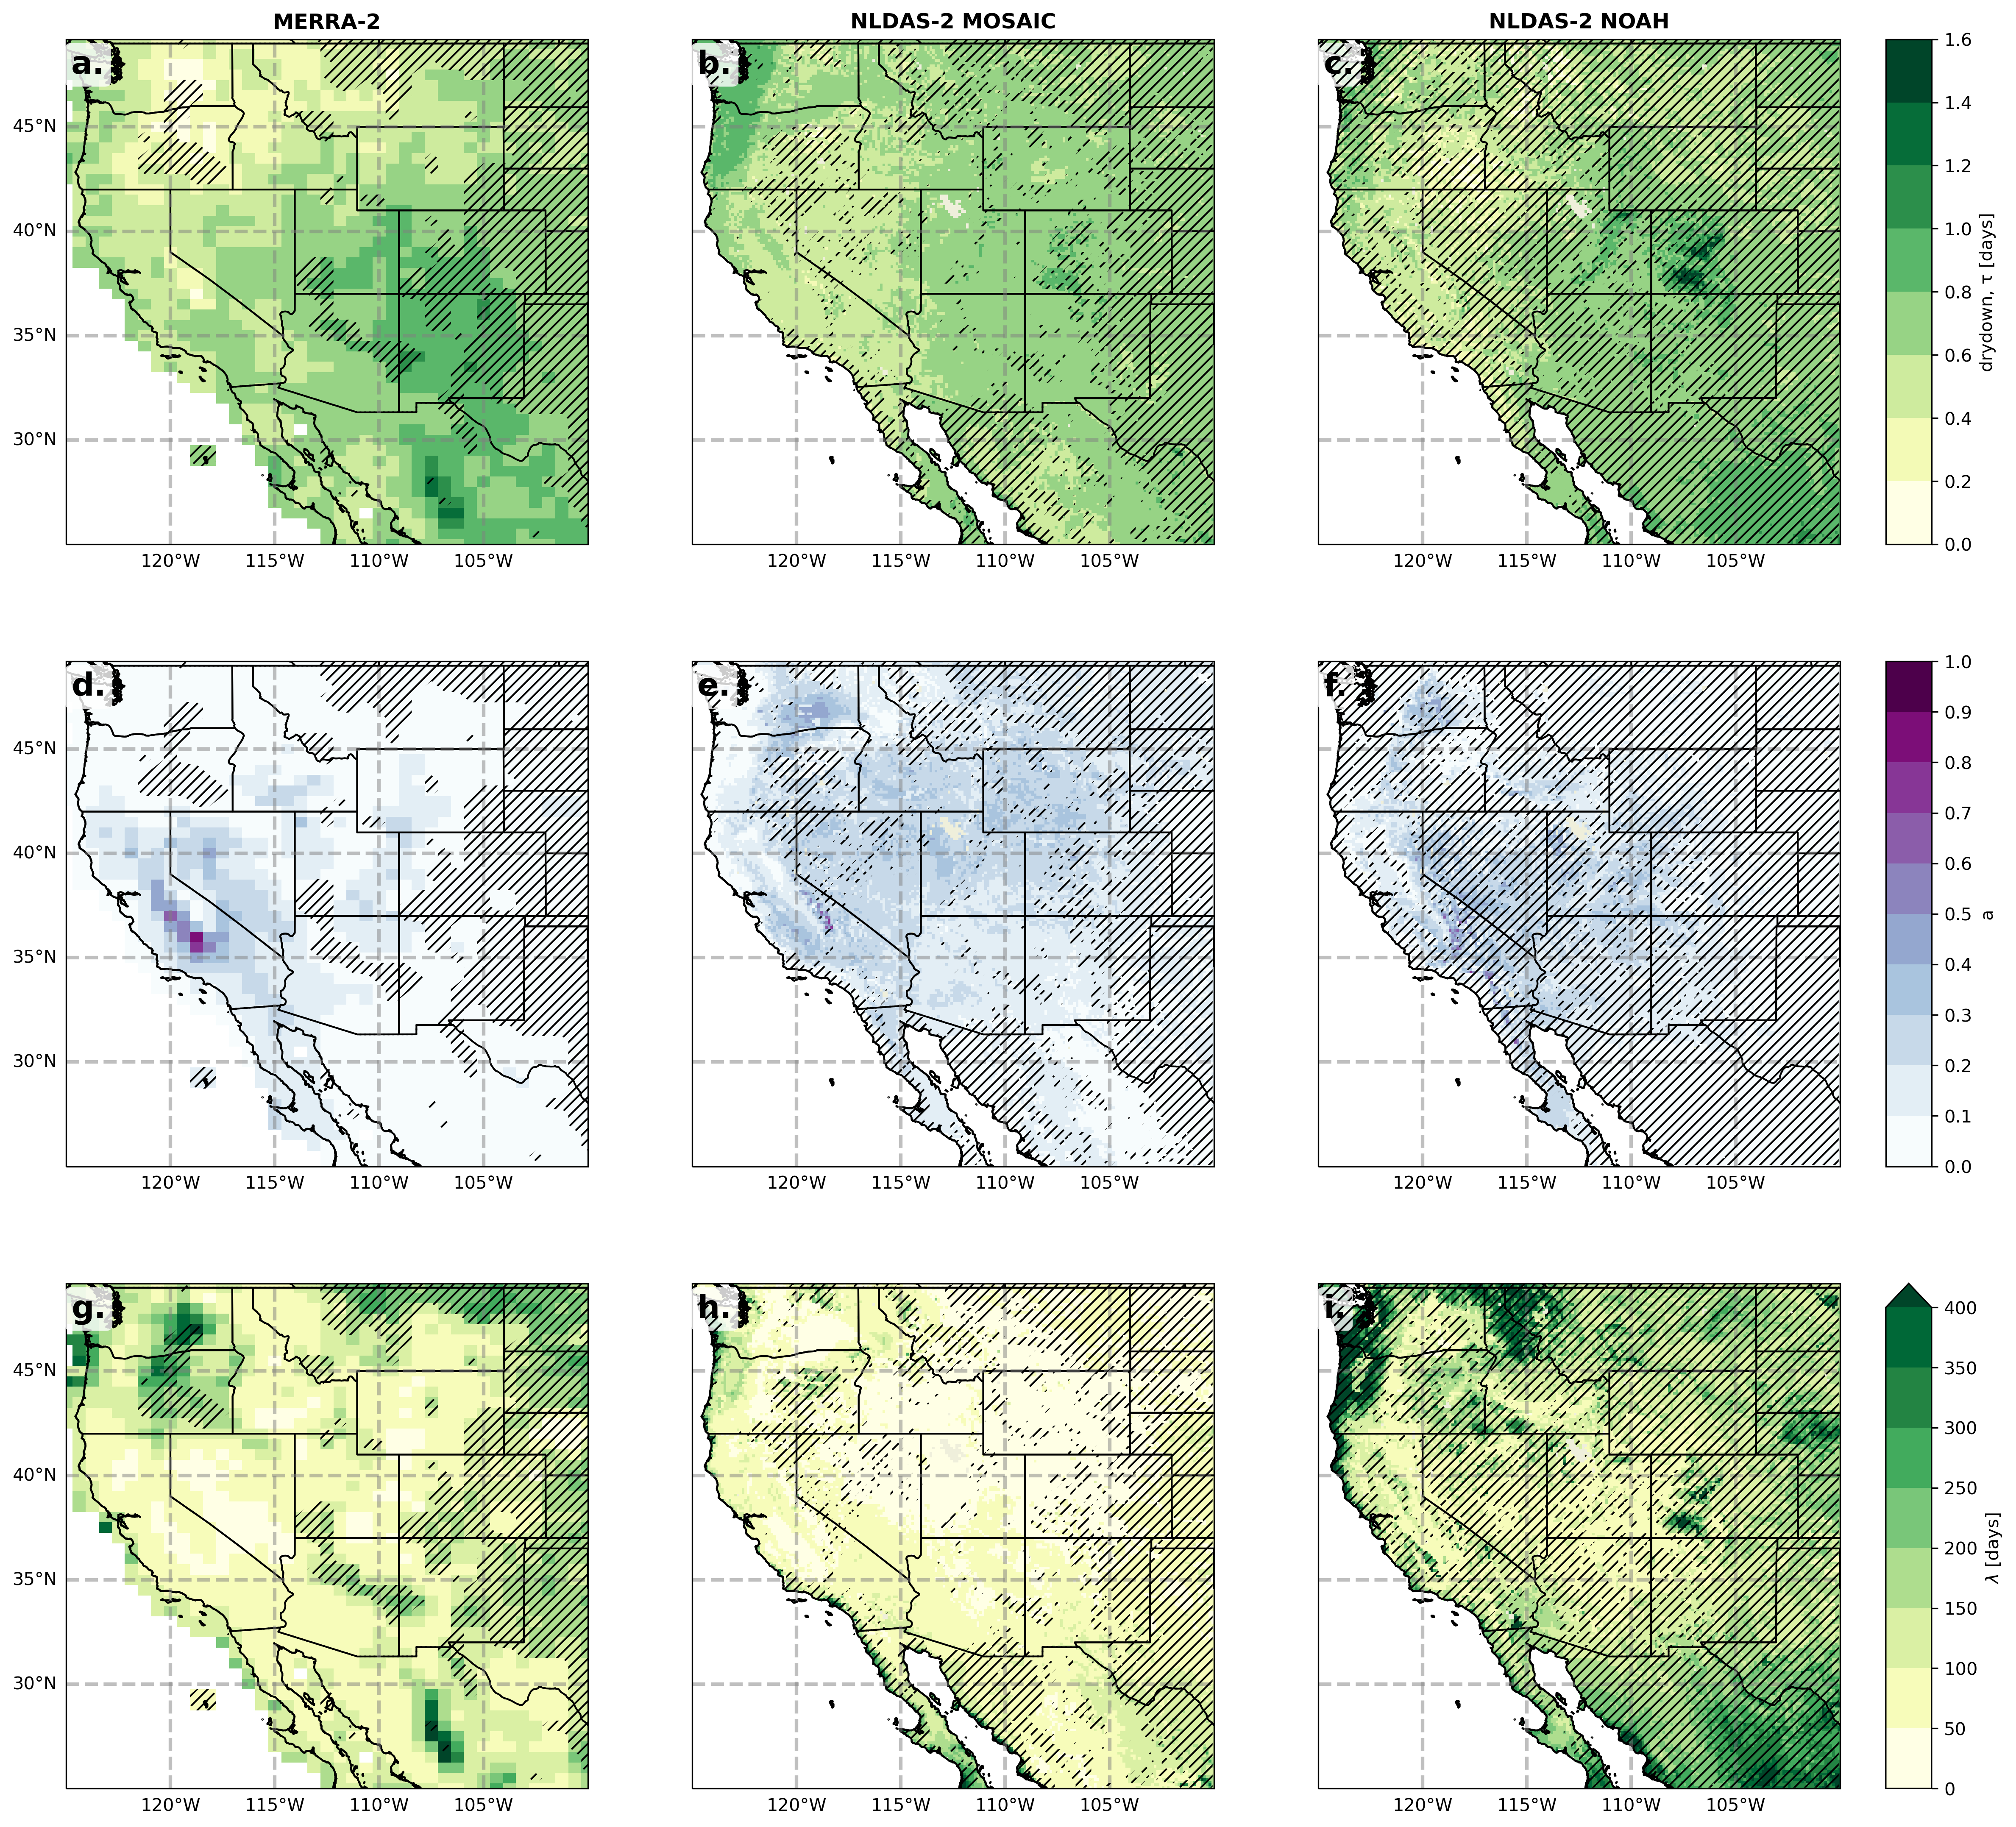

In [69]:
variables = ['tau', 'fitted_a', 'fitted_lambda']
three_by_three_plot(variables, plot_params, hashing = True)

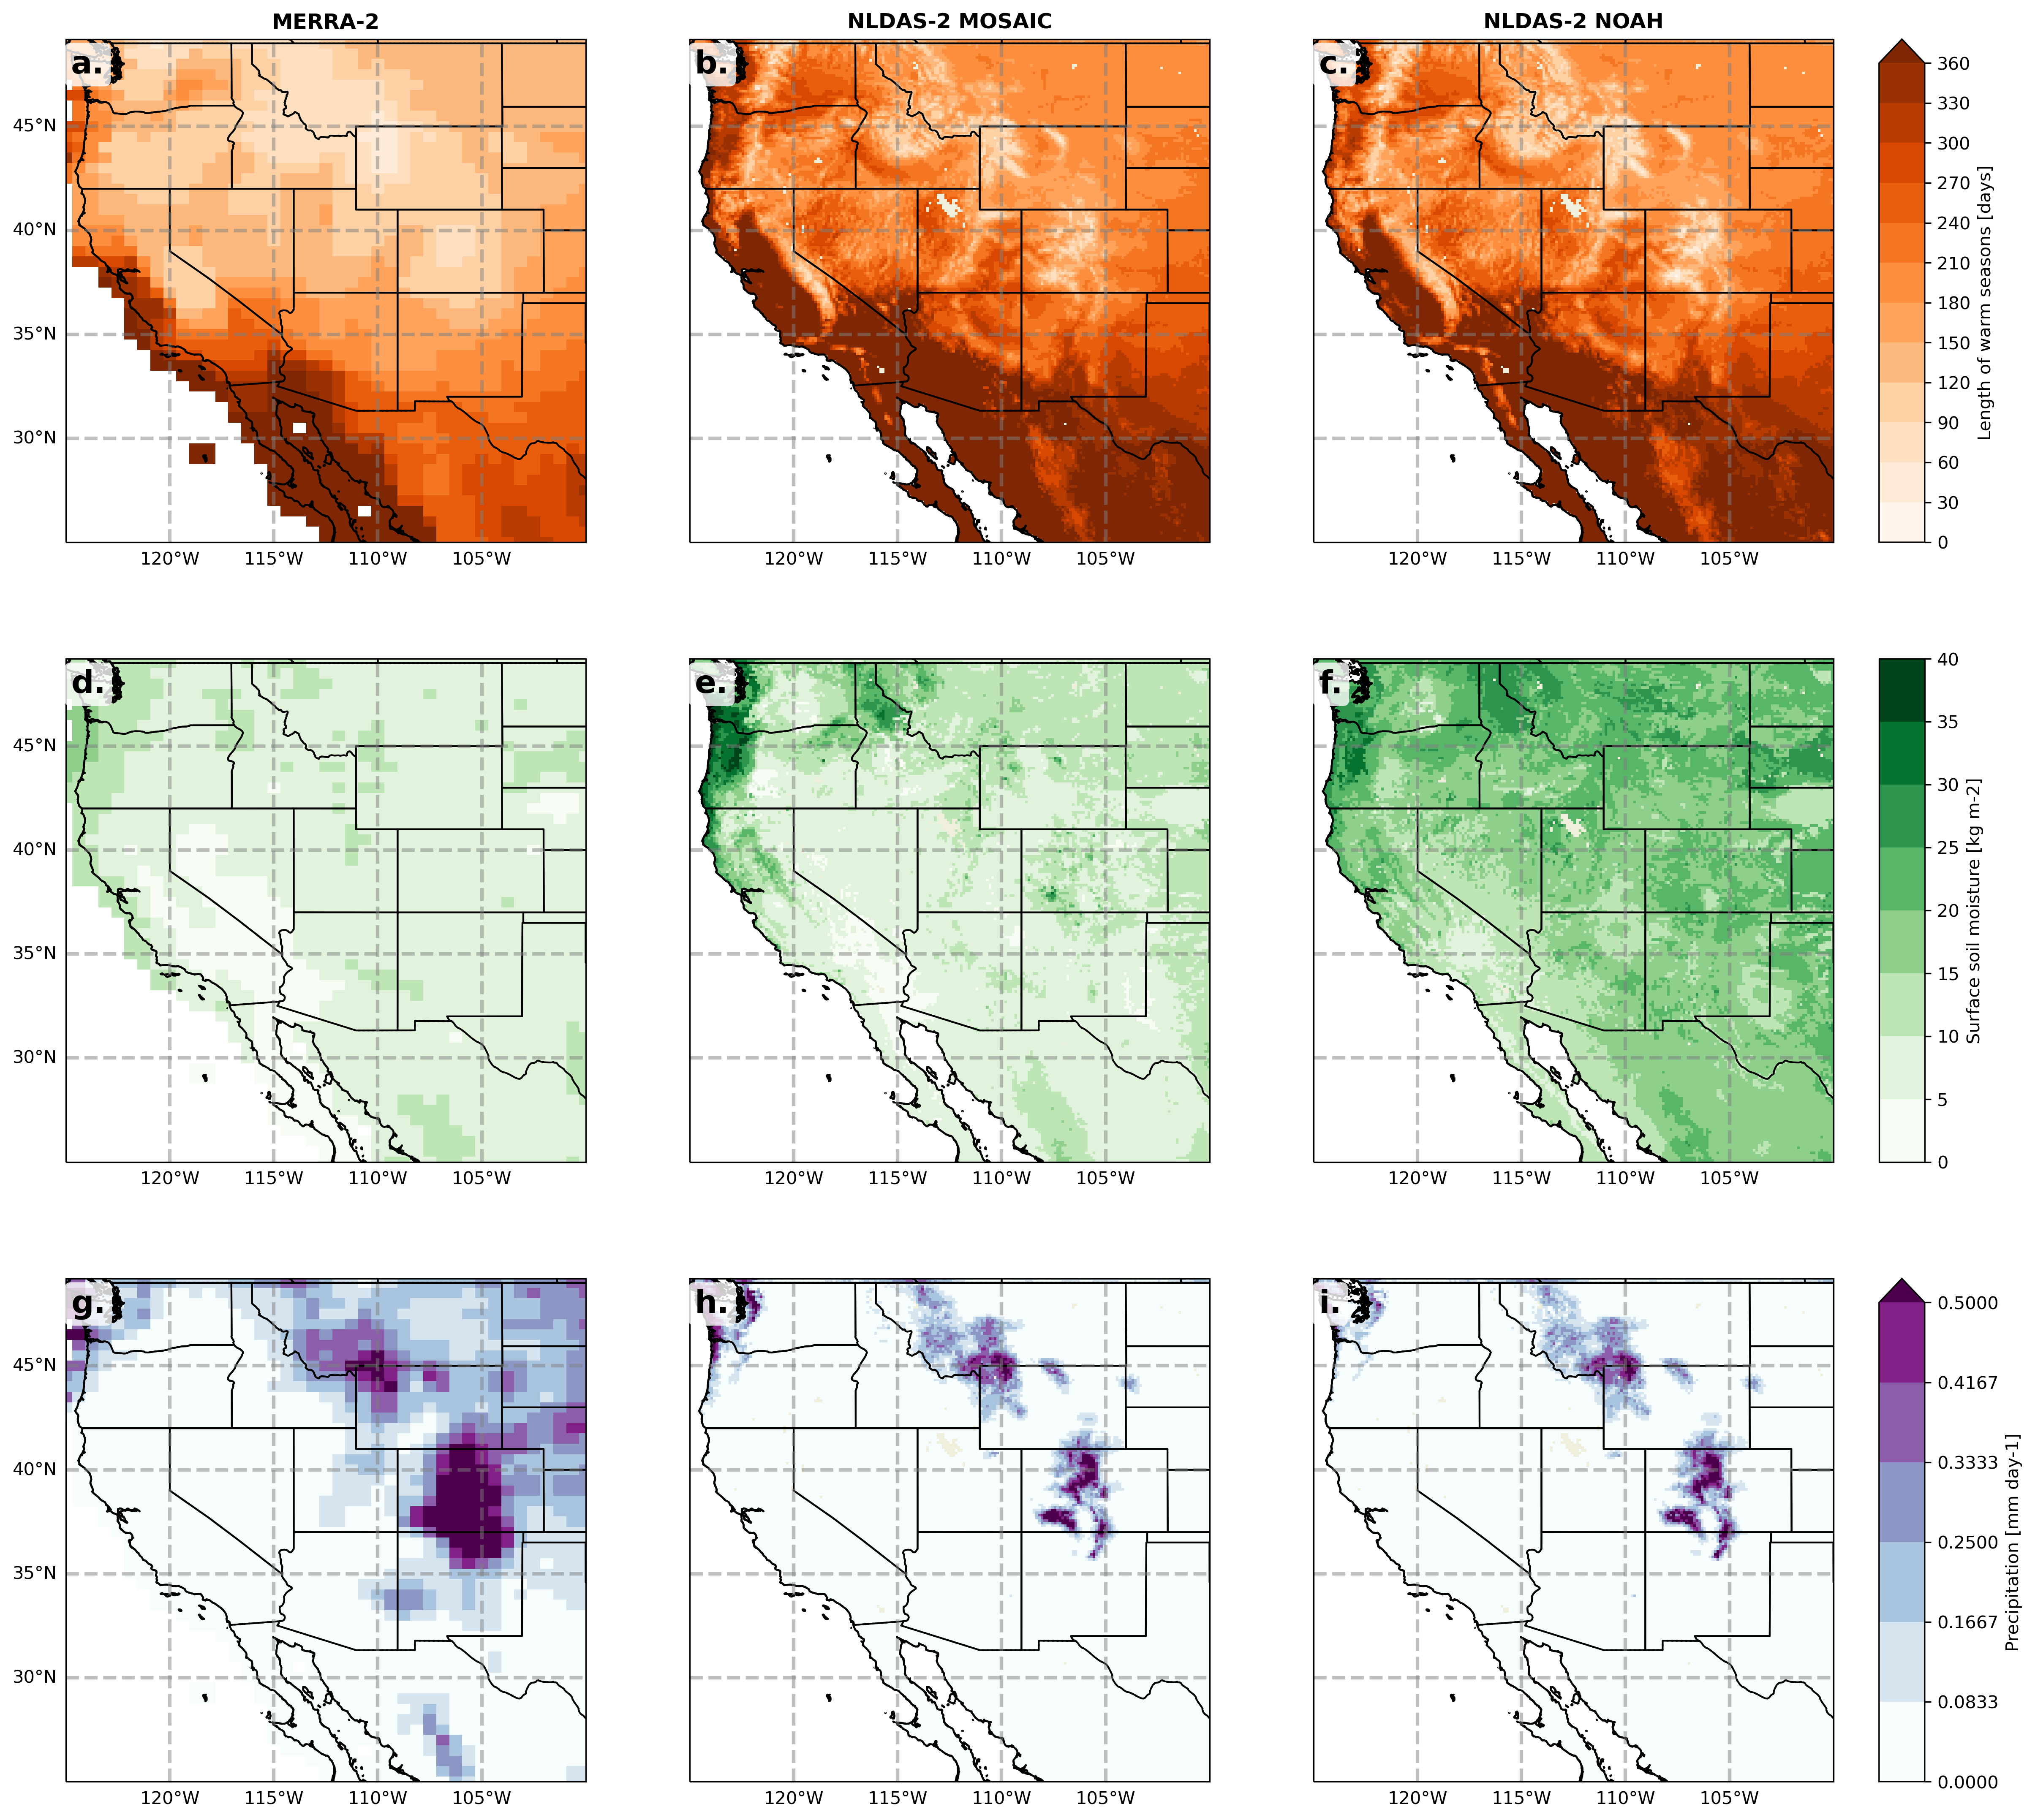

In [70]:
variables = ['length_of_season', 'SFMC', 'P']
three_by_three_plot(variables, plot_params)

## Colorpalette for seaborn plots

In [74]:
colors = ['#67a9cf', 'purple', 'orange']
sns.set_palette(sns.color_palette(colors))

## Boxplots

#### convert both xarray datasets into a combined pandas dataframe for plotting

In [75]:
# Function to convert xarray to pandas and add columns for model and season
def process_dataset(ds, model_name):
    return (ds.to_dataframe()
            .dropna()
            .reset_index()
            .assign(model=model_name))

In [76]:
models_list = []

for model in dict_processed.keys():
    ds_drydown = dict_processed[model]
    ds_warm_season = dict_ds[model][['SFMC', 'P']].groupby('time.year').mean()

    # Merge the two datasets on (lat, lon, year)
    ds_combined = xr.merge([ds_drydown, ds_warm_season])

    df_combined = process_dataset(ds_combined, model)
    
    models_list.append(df_combined)

# Combine all datasets into one DataFrame
combined_df = pd.concat(models_list, ignore_index=True)


#### plot

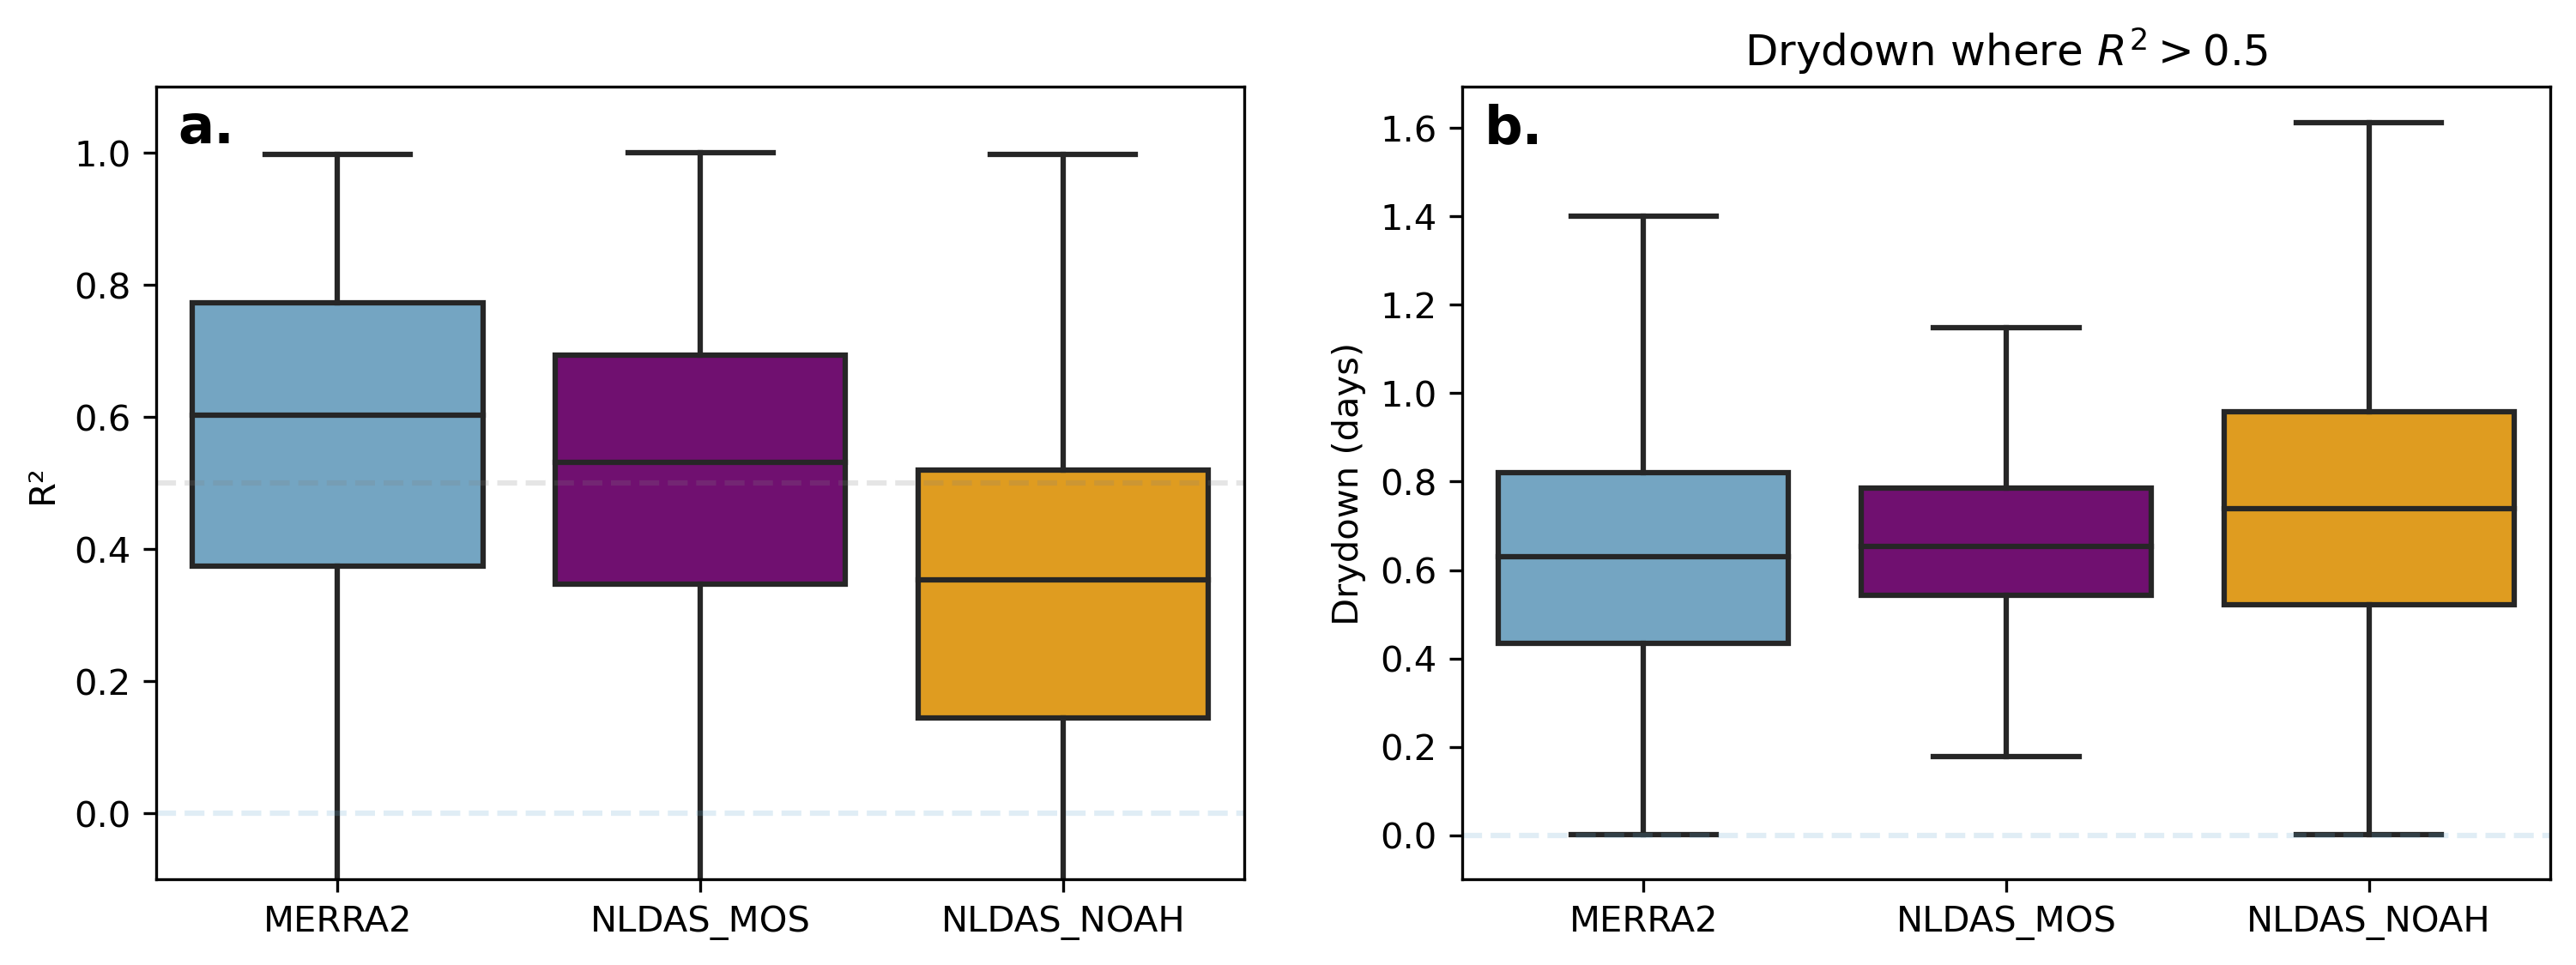

In [81]:
data = combined_df[['model', 'r2', 'tau']]
filtered_data = data[data['r2'] > 0.5]

fig, ax = plt.subplots(ncols = 2, dpi = 300, figsize = (12, 4))


sns.boxplot(x='model', y='r2', data=data, ax = ax[0])
sns.boxplot(x='model', y='tau', data=filtered_data, showfliers=False, ax =ax[1])


ax[0].set_ylim(-0.1, 1.1)
ax[0].axhline(y = 0, linestyle = '--', alpha = 0.2)
ax[0].axhline(y = 0.5, linestyle = '--', alpha = 0.2, color = 'grey', zorder = 1)


ax[0].set_xlabel(None)
ax[0].set_ylabel('R²')

ax[1].set_ylim(-0.1, )

ax[1].axhline(y = 0, linestyle = '--', alpha = 0.2)

ax[1].set_xlabel(None)
ax[1].set_ylabel('Drydown (days)')
ax[1].set_title('Drydown where $R^2 > 0.5$')

subplot_idx = 0
for axis in ax.flat:
    axis.text(0.02, 0.98, string.ascii_lowercase[subplot_idx] + '.', 
                        transform=axis.transAxes, ha='left', va='top',
                        fontsize=15, fontweight='bold',
                        bbox={'boxstyle': 'round',
                              'facecolor': 'white',
                              'alpha': 0.8,
                              'edgecolor': 'None',
                              'pad': 0.2})
    subplot_idx += 1

fig.savefig(f'{fig_save_dir}_R2_and_drydown_filtered_comparison.png', bbox_inches='tight')


In [ ]:
model = 'MERRA2'

total_cells = len(data[data.model == model])
cells_fit = len(data[(data.model == model) & (data.r2 > 0.5)])
percent_fit = np.round((cells_fit/total_cells) * 100, 2)

print(f'Total number of grid cells and years: {total_cells}')
print(f'Grid cells and years with R2 > 0.5: {cells_fit}')
print(f'Percent of grid cells and years with R2 > 0.5: {percent_fit} %')


In [ ]:
summary_data = []
data = combined_df[['model', 'r2', 'tau']]

for model in dict_all.keys():
    total_cells = len(data[data.model == model])
    cells_fit = len(data[(data.model == model) & (data.r2 > 0.5)])
    percent_fit = np.round((cells_fit / total_cells) * 100, 2) if total_cells > 0 else np.nan  # Avoid division by zero

    summary_data.append({
        'model': model,
        'total_cells': total_cells,
        'cells_fit': cells_fit,
        'percent_fit': percent_fit
    })

df_summary = pd.DataFrame(summary_data)

print(df_summary)


In [ ]:
len(data[data.model == 'MERRA2'])

## Scatter Plots 


rename variables to make combining work 

then make scatter plots

In [148]:
# get mean P and SFMC for each (lat, lon) across all years
mean_values = combined_df.groupby(['lat', 'lon'])[['P', 'SFMC']].mean().reset_index()
mean_values.rename(columns={'P': 'P_mean', 'SFMC': 'SFMC_mean'}, inplace=True)

# add the means back into the combined_df
combined_df = combined_df.merge(mean_values, on=['lat', 'lon'], how='left')

# Compute fitted value: a * P_mean / SFMC_mean
combined_df['a * P/M'] = combined_df['fitted_a'] * combined_df['P_mean'] / combined_df['SFMC_mean']


In [149]:
combined_df

lat       lon  year  fitted_lambda  fitted_a       tau        r2  \
0        25.0000 -112.5000  1980      73.946495  0.368383  1.398782  0.558580   
1        25.0000 -112.5000  1981     109.153051  0.110327  0.622480  0.733274   
2        25.0000 -112.5000  1982     175.776918  0.116567  1.058951  0.178952   
3        25.0000 -112.5000  1983     128.063140  0.055926  0.370726  0.723486   
4        25.0000 -112.5000  1984     151.455368  0.052124  0.408682  0.558813   
...          ...       ...   ...            ...       ...       ...       ...   
2877676  49.9375 -100.0625  2019     169.153750  0.067387  0.790367  0.363562   
2877677  49.9375 -100.0625  2020     116.907157  0.088545  0.717234  0.644492   
2877678  49.9375 -100.0625  2021      87.574676  0.137809  0.834778  0.285036   
2877679  49.9375 -100.0625  2022     162.635193  0.001000  0.011303 -2.632735   
2877680  49.9375 -100.0625  2023      97.649042  0.108886  0.736189  0.185009   

         length_of_season       SFMC         P       model    P_mean  \
0                   366.0   4.304957  0.132639      MERRA2  0.412594   
1                   365.0   5.175084  0.372228      MERRA2  0.412594   
2                   365.0   4.923547  0.319275      MERRA2  0.412594   
3                   365.0   6.333046  0.793312      MERRA2  0.412594   
4                   366.0   6.242065  0.847999      MERRA2  0.412594   
...                   ...        ...       ...         ...       ...   
2877676             181.0  21.248386  2.219773  NLDAS_NOAH  1.641743   
2877677             158.0  19.388208  1.138880  NLDAS_NOAH  1.641743   
2877678             200.0  18.963627  1.303258  NLDAS_NOAH  1.641743   
2877679             180.0  23.213938  2.171242  NLDAS_NOAH  1.641743   
2877680             187.0  21.364119  1.644963  NLDAS_NOAH  1.641743   

         SFMC_mean   a * P/M  
0         5.097764  0.029816  
1         5.097764  0.008929  
2         5.097764  0.009434  
3         5.097764  0.004526  
4         5.097764  0.004219  
...            ...       ...  
2877676  17.756045  0.006231  
2877677  17.756045  0.008187  
2877678  17.756045  0.012742  
2877679  17.756045  0.000092  
2877680  17.756045  0.010068  

[2877681 rows x 14 columns]

In [159]:
data = combined_df[(combined_df.r2 > 0.5)][['tau', 'fitted_a', 'SFMC_mean', 'a * P/M', 'model']].reset_index()

In [179]:
# g = sns.FacetGrid(data, col="model")
# g.map(sns.stripplot,  "tau", "fitted_a")


In [202]:
print(r'$\lambda$')

$\lambda$


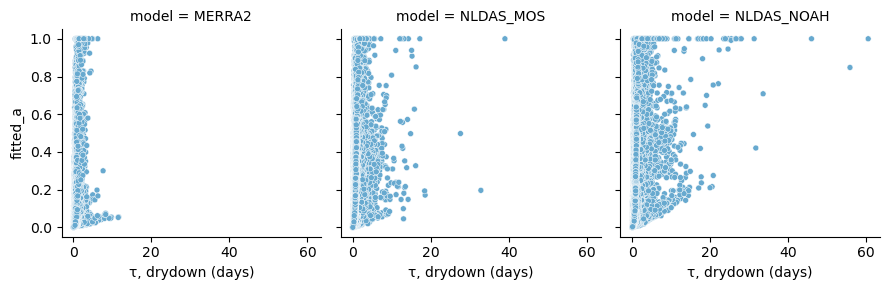

In [209]:
g = sns.FacetGrid(data, col="model")
g.map(sns.scatterplot, "tau",  "fitted_a", size = 2)
g.set_axis_labels("τ, drydown (days)")

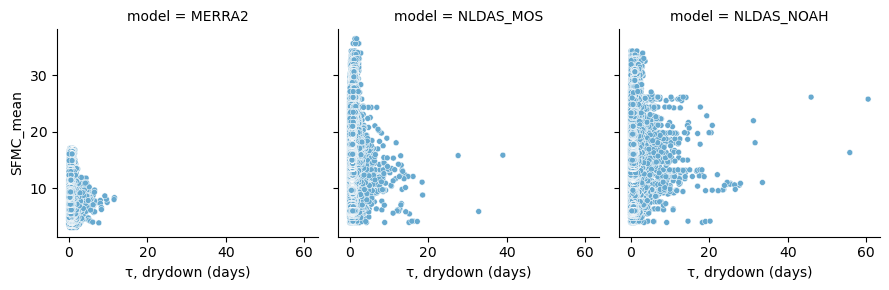

In [210]:
g = sns.FacetGrid(data, col="model")
g.map(sns.scatterplot, "tau",  "SFMC_mean", size = 2)
g.set_axis_labels("τ, drydown (days)")

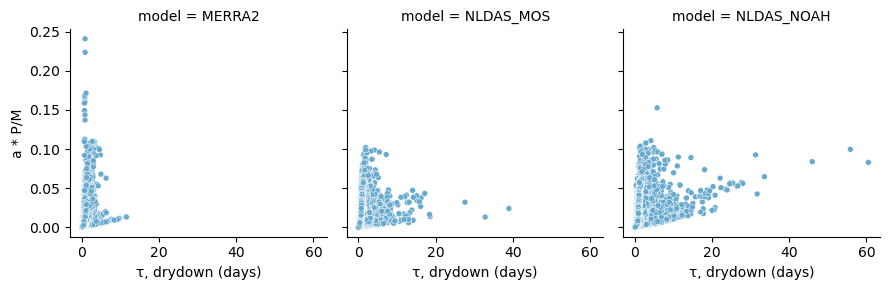

In [211]:
g = sns.FacetGrid(data, col="model")
g.map(sns.scatterplot, "tau",  "a * P/M", size = 2)
g.set_axis_labels("τ, drydown (days)")

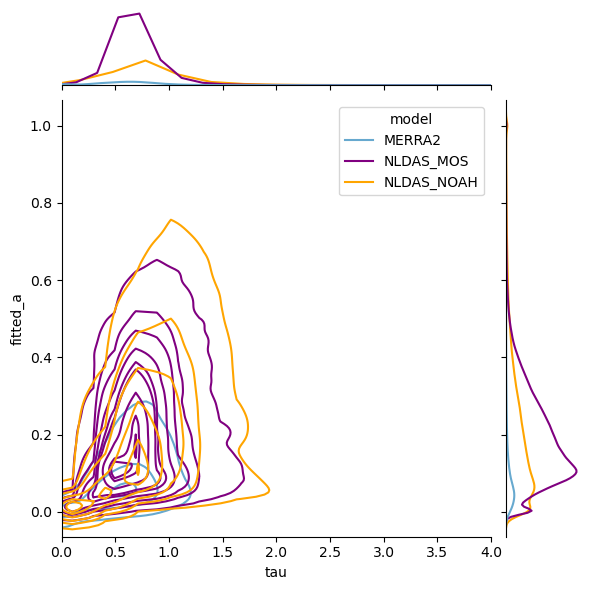

In [172]:
sns.jointplot(data = data, x = 'tau', y = 'fitted_a', xlim = (0, 4), hue = 'model', kind = 'kde')

/opt/anaconda3/envs/climate/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


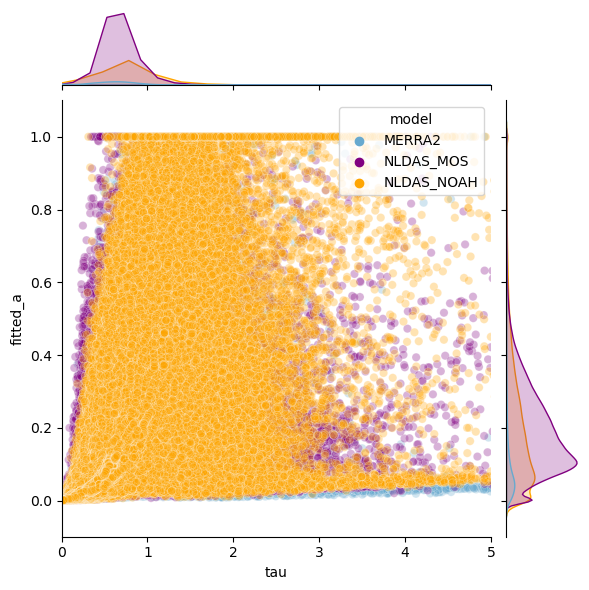

In [173]:
#g = sns.jointplot(data = data, x = 'tau', y = 'fitted_a', hue = 'model')
#g.ax_joint.set_xscale('log')

sns.jointplot(data = data, x = 'tau', y = 'fitted_a', hue = 'model', alpha = 0.3, xlim = (0, 5))

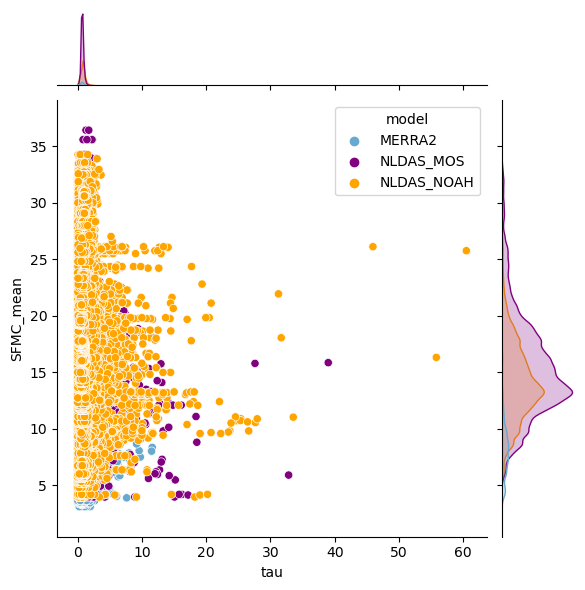

In [161]:
sns.jointplot(data = data, x = 'tau', y = 'SFMC_mean', hue = 'model')

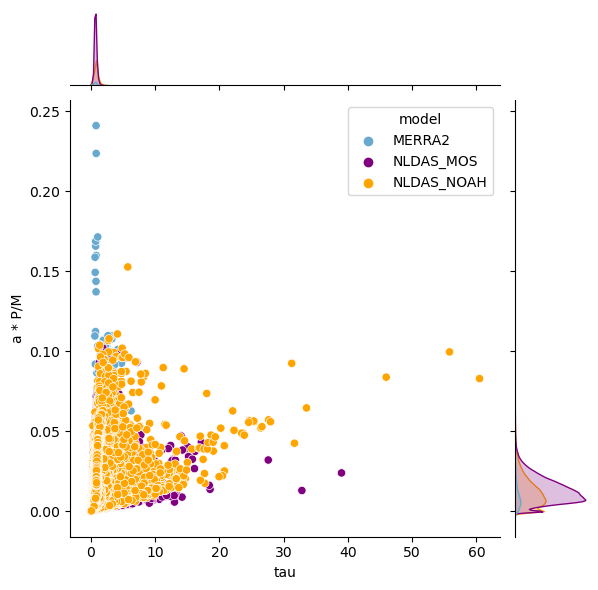

In [162]:
sns.jointplot(data = data, x = 'tau', y = 'a * P/M', hue = 'model')

### Looking at average over the entire time period because it is easier 

In [133]:
models_list = []

for model in dict_processed.keys():
    ds_drydown = global_mean(dict_processed[model])
    ds_warm_season = global_mean(dict_ds[model][['SFMC', 'P']].groupby('time.year').mean())

    # Merge the two datasets on (lat, lon, year)
    ds_combined = xr.merge([ds_drydown, ds_warm_season])

    df_combined = process_dataset(ds_combined, model)
    
    models_list.append(df_combined)

# Combine all datasets into one DataFrame
combined_mean_df = pd.concat(models_list, ignore_index=True)

In [139]:
combined_mean_df

year  fitted_lambda  fitted_a       tau        r2  length_of_season  \
0    1980     164.300724  0.092542  0.850392  0.588270        182.394436   
1    1981     146.979365  0.104585  0.667321  0.539654        194.769654   
2    1982     154.880381  0.067154  0.652930  0.537505        177.652061   
3    1983     136.884902  0.057128  0.565891  0.601435        185.200500   
4    1984     139.323731  0.066390  0.610768  0.588074        180.866996   
..    ...            ...       ...       ...       ...               ...   
127  2019     196.427347  0.134376  0.633715  0.234261        243.021531   
128  2020     179.389783  0.121639  0.656572  0.426758        242.190772   
129  2021     187.153414  0.180720  0.890366  0.318410        254.797735   
130  2022     235.447173  0.133163  0.738118  0.360532        247.982739   
131  2023     227.645104  0.140122  0.759092  0.137600        251.263071   

          SFMC         P       model  
0     7.917044  1.080780      MERRA2  
1     8.293348  1.248742      MERRA2  
2     8.580894  1.275473      MERRA2  
3     9.365611  1.422452      MERRA2  
4     8.754112  1.324586      MERRA2  
..         ...       ...         ...  
127  18.631350  1.292893  NLDAS_NOAH  
128  16.740725  0.868514  NLDAS_NOAH  
129  17.089209  1.021994  NLDAS_NOAH  
130  17.511702  1.077245  NLDAS_NOAH  
131  18.244274  1.197513  NLDAS_NOAH  

[132 rows x 9 columns]

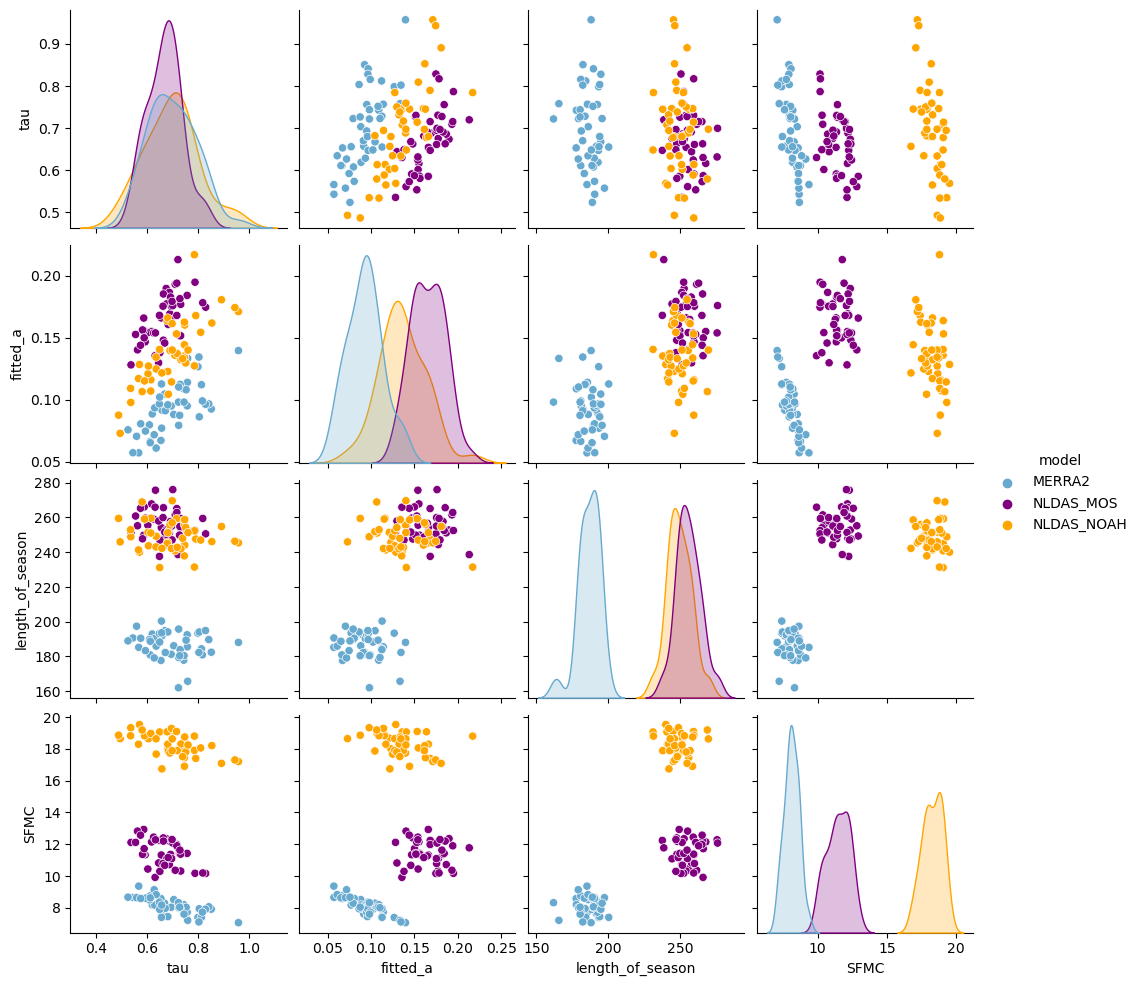

In [138]:
data = combined_mean_df[['tau', 'fitted_a', 'length_of_season', 'SFMC', 'model']]

sns.pairplot(data, hue = 'model')